In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from PIL import Image
import pandas as pd
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, random_split

### Load and Process Dataset

In [2]:
def split_train_for_val(train_df):
    #take 15% of the train data for validation set
    #do a random split
    x = train_df.iloc[:, 1:]
    y = train_df.iloc[:, 0]
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    for train_idx, val_idx in split.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    x_val.insert(loc=0, value = y_val, column='label')
    x_train.insert(loc=0, value = y_train, column='label')

    return x_train, x_val

In [3]:
data_path = "./dataset/archive/"
# dataset from https://www.kaggle.com/datasets/datamunge/sign-language-mnist/

test_df = pd.read_csv(data_path+'sign_mnist_test/sign_mnist_test.csv')
train_df = pd.read_csv(data_path+'sign_mnist_train/sign_mnist_train.csv')

train_df, val_df = split_train_for_val(train_df)

In [4]:
def dataset_to_tensor(test, train, val):
    train_images = train.iloc[:, 1:].to_numpy(dtype = 'float32')
    test_images = test.iloc[:, 1:].to_numpy(dtype = 'float32')
    val_images = val.iloc[:, 1:].to_numpy(dtype = 'float32')
    train_labels = train['label'].values
    test_labels = test['label'].values
    val_labels = val['label'].values

    train_ds = torch.from_numpy(train_images.reshape(train_images.shape[0],1,28,28))
    train_label_ds = torch.from_numpy(train_labels)

    test_ds = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
    test_label_ds = torch.from_numpy(test_labels)

    val_ds = torch.from_numpy(val_images.reshape(val_images.shape[0],1,28,28))
    val_label_ds = torch.from_numpy(val_labels)

    train_ds = TensorDataset(train_ds, train_label_ds)
    test_ds = TensorDataset(test_ds, test_label_ds)
    val_ds = TensorDataset(val_ds, val_label_ds)
    return train_ds, test_ds, val_ds

In [5]:
train_ds, test_ds, val_ds = dataset_to_tensor(test_df, train_df, val_df)

### Define Training Vars

In [6]:
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate within [-15, 15] degrees
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(28, scale=(0.85, 1.15)),  # For 28x28 input size
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

batch_size = 32
shuffle = True
num_workers = 4  # Number of CPU processes for data loading

In [7]:
train_ds.transform = data_transforms
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

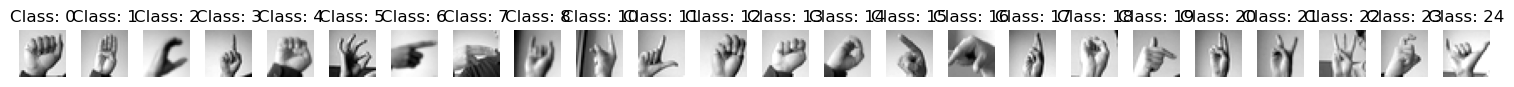

In [8]:
num_classes = 26
sampled_images = {i: None for i in range(num_classes)}

# Iterate over the dataloader until an image from each class is sampled
for images, labels in train_loader:
    for img, label in zip(images, labels):
        if sampled_images[label.item()] is None:
            sampled_images[label.item()] = img
        if all(val is not None for val in sampled_images.values()):
            break

# Plot the sampled images
sampled_images = {k: v for k, v in sampled_images.items() if v is not None}
fig, axes = plt.subplots(1, num_classes-2, figsize=(15, 3)) # -2 since we dont have two classes that require motion

for ax, (class_idx, img) in zip(axes, sampled_images.items()):
    # Depending on your data normalization and image shape, you might need to adjust the following line
    ax.imshow(img.squeeze().numpy(), cmap='gray')  # assuming grayscale images
    ax.set_title(f'Class: {class_idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Define Model and Metrics

In [9]:

def evaluate_on_test(model, test_loader, criterion, device):
    """
    Evaluate a PyTorch model on a test dataset.

    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - criterion (torch.nn.Module): The loss function.
    - device (torch.device): Device ("cuda" or "cpu").

    Returns:
    - test_loss (float): The evaluation loss on the test set.
    - test_accuracy (float): The evaluation accuracy on the test set.
    """
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            # Calculate the number of correct predictions
            _, predicted = outputs.max(1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_test_loss = total_loss / total_samples
    test_accuracy = correct_predictions / total_samples

    return avg_test_loss, test_accuracy


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        scheduler.step(result['val_loss'])
    return history

In [10]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Define the layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 29)  # 29 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def forward(self, x):
        # First convolution + pooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolution + pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)

        # Third convolution + pooling
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 3 * 3)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second fully connected layer (output layer)
        x = self.fc2(x)
        return x

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


### Train Model and Save

In [11]:
model = CustomCNN()
fit(10, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7772, val_acc: 0.7601
Epoch [1], val_loss: 0.3417, val_acc: 0.9087
Epoch [2], val_loss: 0.2546, val_acc: 0.9376
Epoch [3], val_loss: 0.2102, val_acc: 0.9560
Epoch [4], val_loss: 0.1668, val_acc: 0.9699
Epoch [5], val_loss: 0.1768, val_acc: 0.9630
Epoch [6], val_loss: 0.1864, val_acc: 0.9616
Epoch [7], val_loss: 0.1469, val_acc: 0.9779
Epoch [8], val_loss: 0.1447, val_acc: 0.9792
Epoch [9], val_loss: 0.1485, val_acc: 0.9712


[{'val_loss': 0.7772447466850281, 'val_acc': 0.7601007223129272},
 {'val_loss': 0.34172630310058594, 'val_acc': 0.9087251424789429},
 {'val_loss': 0.25462937355041504, 'val_acc': 0.9375526309013367},
 {'val_loss': 0.21019668877124786, 'val_acc': 0.9559634923934937},
 {'val_loss': 0.16676394641399384, 'val_acc': 0.9698664546012878},
 {'val_loss': 0.17684248089790344, 'val_acc': 0.9629886746406555},
 {'val_loss': 0.18636177480220795, 'val_acc': 0.9616299867630005},
 {'val_loss': 0.14692182838916779, 'val_acc': 0.9778606295585632},
 {'val_loss': 0.1446605622768402, 'val_acc': 0.9791666865348816},
 {'val_loss': 0.1485479176044464, 'val_acc': 0.9711724519729614}]

In [12]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion, device)
print(test_loss, test_acc)

0.22821332544412481 0.9353039598438372


In [13]:
# Save
torch.save(model, 'trained_model.pth')

### Analysis

In [14]:
# Load model and data
model = torch.load('trained_model.pth')
data_path = "./dataset/archive/"
test_df = pd.read_csv(data_path+'sign_mnist_test/sign_mnist_test.csv')
X = test_df.drop('label', axis=1).values  # Features - drops the label column and converts to numpy array
y = test_df['label'].values  # Labels
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [15]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

count_parameters(model)

Total parameters: 395293
Trainable parameters: 395293
Non-trainable parameters: 0


In [16]:
#basic data processing
test_images = test_df.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels = test_df['label'].values

test_ds = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
test_label_ds = torch.from_numpy(test_labels)

test_ds = TensorDataset(test_ds, test_label_ds)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False, num_workers=4)

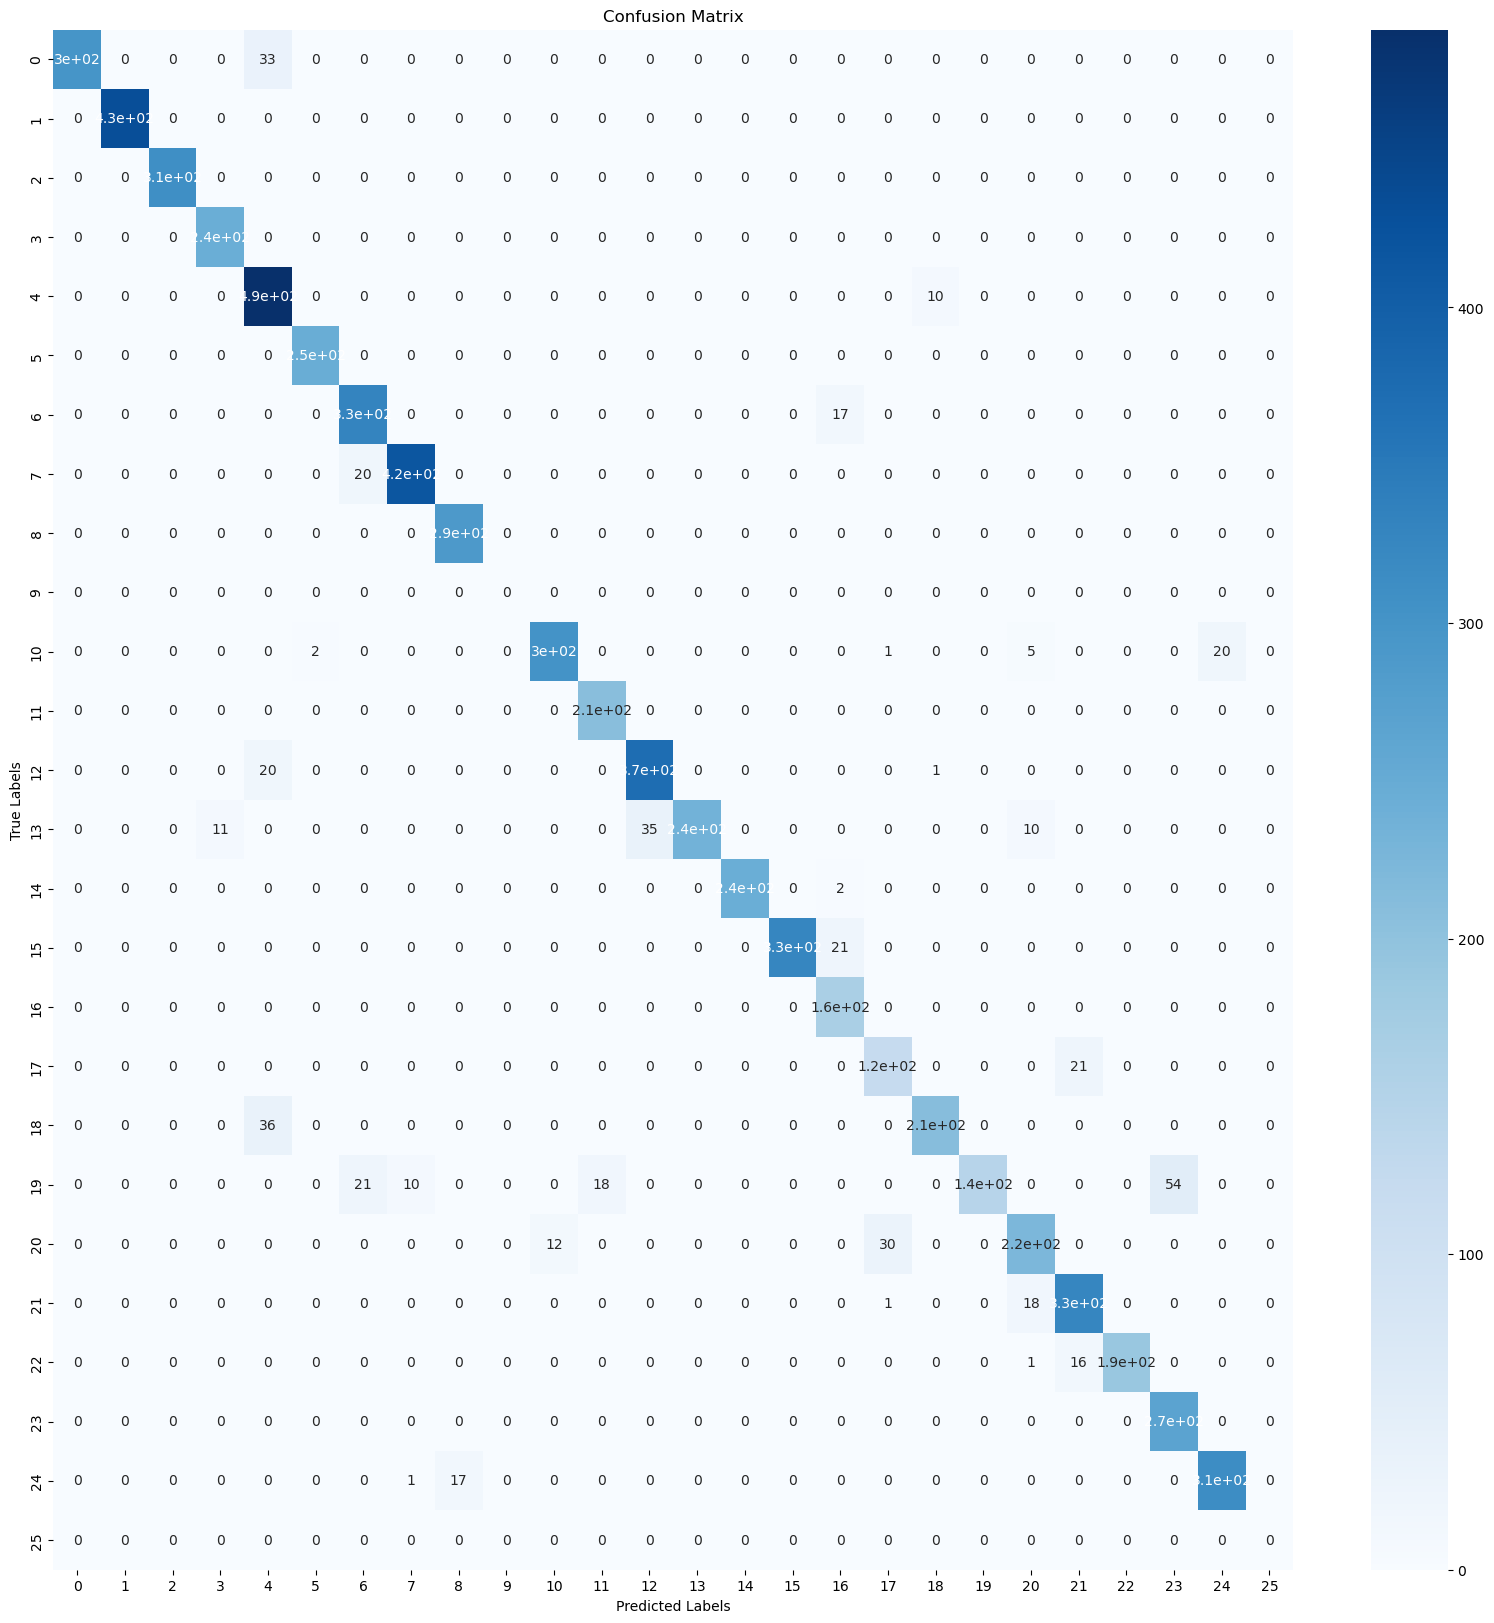

In [17]:
#load in confusion matrix to see what the model confuses the most

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions
preds, labels = get_predictions(model, test_loader)

# Compute confusion matrix
conf_mat = confusion_matrix(labels, preds)

row_index = 9
col_index = 9

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

row_index = 25
col_index = 25

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

# Plot confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
                   9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
                   17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
                   25: 'Z'}


# picking the ones with the highest confusion - above 25
true_to_common_confusion = [
                            # (6,7), # also (7, 6)
                            # (6,16), 
                            # (8,24), 
                            # (10,24), 
                            (13, 0),
                            (13,12), 
                            (13, 12, 0, 20)
                            # (13,20), 
                            # (15,16), 
                            # (17,11), 
                            # (18,4),
                            # (19,7), 
                            # (19,23),
                            ]

In [19]:
test_arrays = dict()
for i in range(25):
    if i != 9:
        test_df_a = test_df.loc[test_df['label'] == i]#.sample()
        test_images = test_df_a.iloc[:, 1:].to_numpy(dtype = 'float32')
        test_labels = test_df['label'].values
        test_np = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
        test_arrays[i] = test_np


# test_df_0 = test_df.loc[test_df['label'] == 0]#.sample()
# test_images_0 = test_df_0.iloc[:, 1:].to_numpy(dtype = 'float32')
# test_labels_0 = test_df_0['label'].values
# test_np_0 = torch.from_numpy(test_images_0.reshape(test_images_0.shape[0],1,28,28))

In [20]:
model.eval()  # Set the model to evaluation mode

# Define the hook function to capture activations
all_activations = {}
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hook = model.fc1.register_forward_hook(get_activation('fc1'))

#get model activations for all the negative and postive examples we want to pull
for i in range(25):
    if i != 9:
        output = model(test_arrays[i])
        all_activations[i] = activations['fc1']


# Unregister the hook
hook.remove()
# print(all_activations)

In [21]:

#format the activations to run PCA
formatted_activations = torch.cat([all_activations[key] for key in all_activations], dim=0)

labels_activations = torch.cat([key*torch.ones(all_activations[key].size(0)) for key in all_activations])


pairs with confusion: [(13, 0), (13, 12), (13, 12, 0, 20)]
no confusion examples: [(0, 15), (0, 22)]


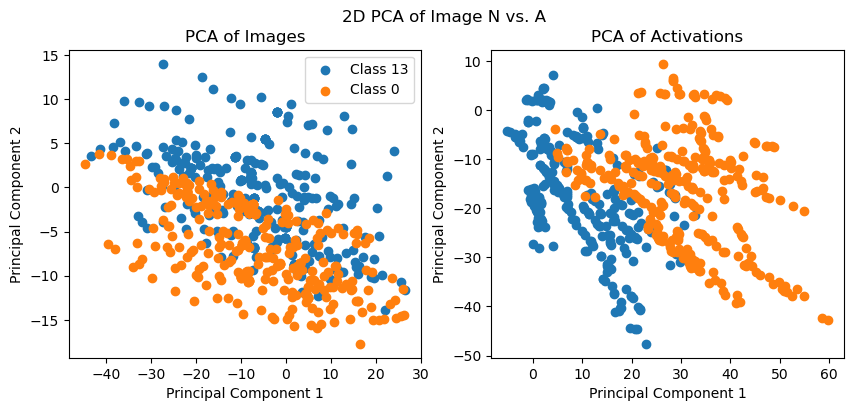

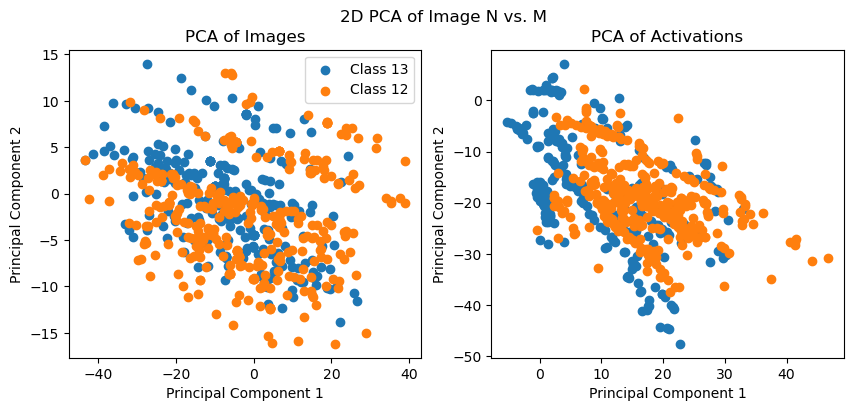

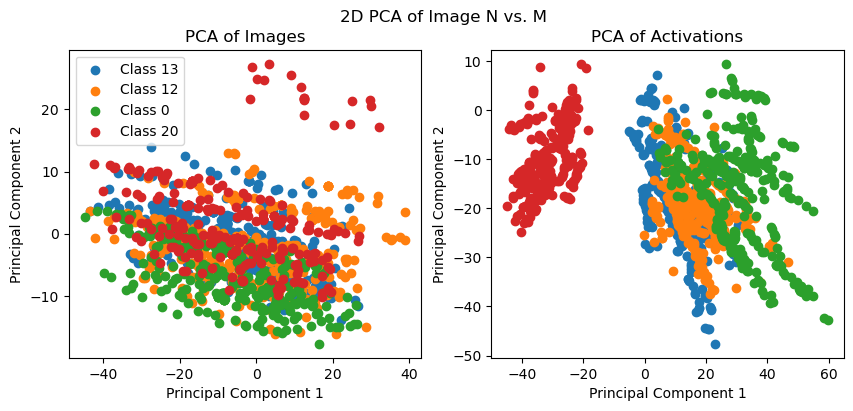

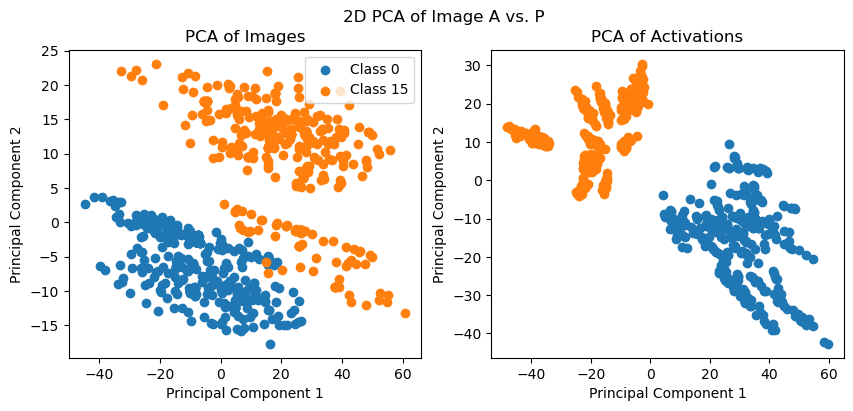

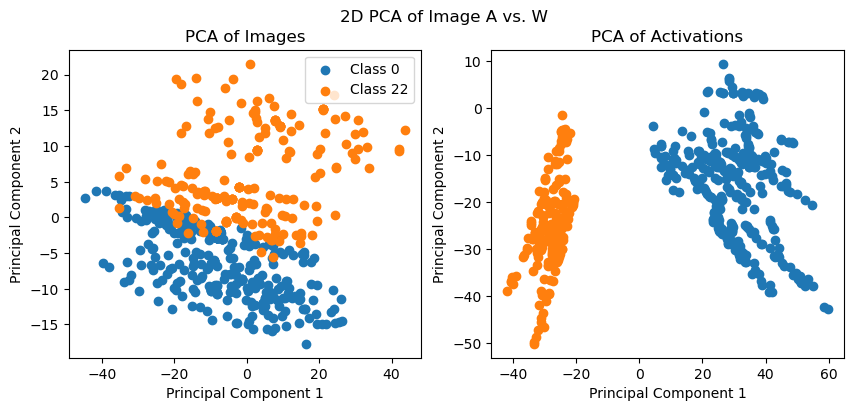

In [22]:
#PCA run on all the different classes
negative_examples = [(0,15),
                     (0,22)]
pairs_to_analyze = true_to_common_confusion + negative_examples

print(f'pairs with confusion: {true_to_common_confusion}')
print(f'no confusion examples: {negative_examples}')

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)
activations_pca = pca.fit_transform(formatted_activations)

# Visualization
for pair in pairs_to_analyze:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y == target, 0], 
                    principal_components[y == target, 1], 
                    label=f"Class {target}")
        ax[1].scatter(activations_pca[labels_activations == target, 0], 
                    activations_pca[labels_activations == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

pairs with confusion: [(13, 0), (13, 12), (13, 12, 0, 20)]
no confusion examples: [(0, 15), (0, 22)]


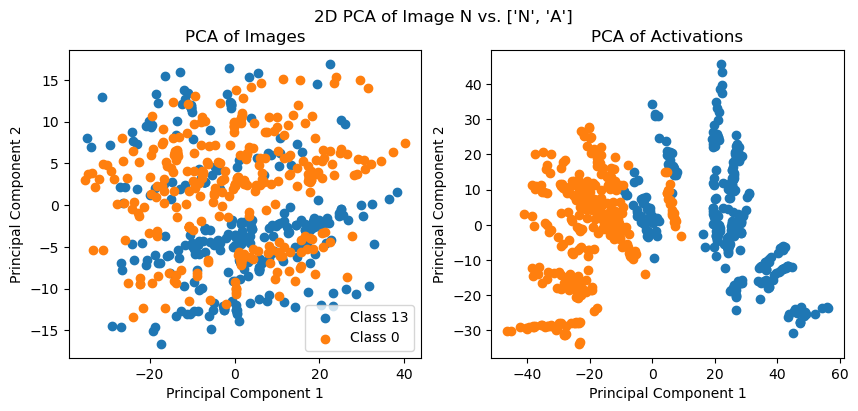

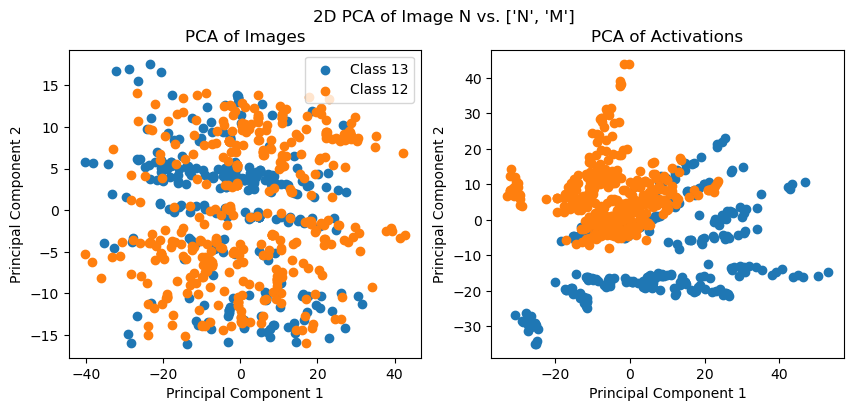

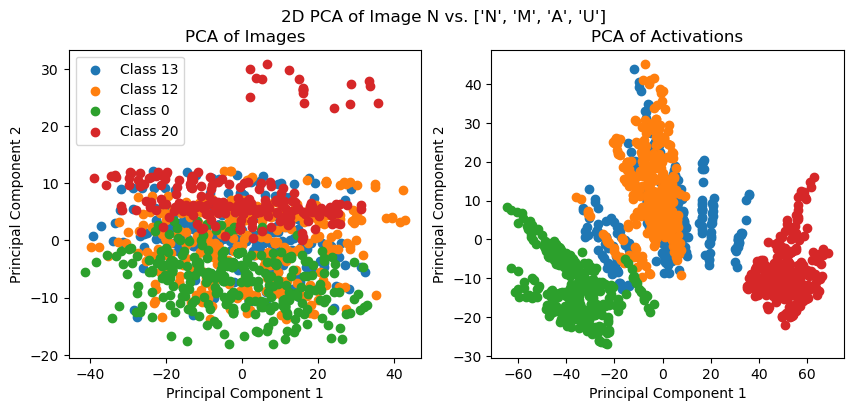

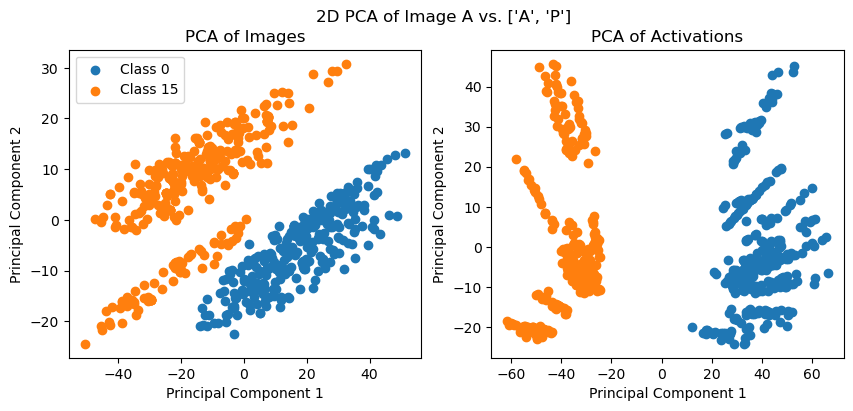

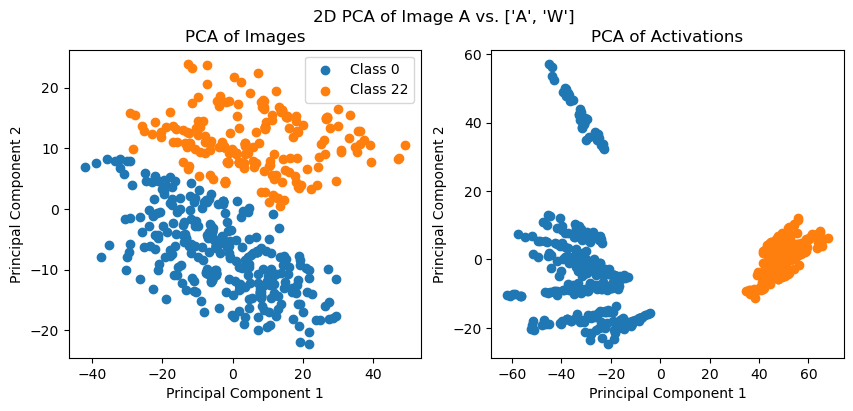

In [23]:
#PCA running on only the pairs
print(f'pairs with confusion: {true_to_common_confusion}')
print(f'no confusion examples: {negative_examples}')
pca = PCA(n_components=2)


# Visualization
for pair in pairs_to_analyze:
    mask = np.logical_or.reduce([y == label for label in pair])
    # Filter the data using the mask
    X_stan_filtered = X_standardized[mask]
    y_filtered = y[mask]
    mask_act = np.logical_or.reduce([labels_activations == label for label in pair])
    filtered_activations = formatted_activations[mask_act]
    labels_act_filtered = labels_activations[mask_act]
    principal_components = pca.fit_transform(X_stan_filtered)
    activations_pca = pca.fit_transform(filtered_activations)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y_filtered == target, 0], 
                    principal_components[y_filtered == target, 1], 
                    label=f"Class {target}")
        
        ax[1].scatter(activations_pca[labels_act_filtered == target, 0], 
                    activations_pca[labels_act_filtered == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {[index_to_letter[j] for j in pair]}")
    plt.show()